## 1 Info & Config

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.192
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
!pwd

/content


In [ ]:
# 真实音频文件的地址前缀
ground_truth_path_prefix = '/content/seedtts_testset/zh/wavs/'
# 生成的音频文件的地址前缀
generated_path_prefix = '/content/seedtts_testset/zh/generate-wavs/'
# 采样频率
sample_rate = 16_000

## 2 Clone Repo

In [ ]:
!cd /content
!rm -rf sample_data ChatTTS
!git clone https://github.com/2noise/ChatTTS.git

Cloning into 'ChatTTS'...
remote: Enumerating objects: 2685, done.
remote: Counting objects: 100% (765/765), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 2685 (delta 538), reused 454 (delta 453), pack-reused 1920 (from 3)
Receiving objects: 100% (2685/2685), 8.02 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (1608/1608), done.


## 3 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 4 Install Testset

In [ ]:
!tar -xvf /content/drive/MyDrive/Colab\ Notebooks/seedtts_testset.tar

In [ ]:
Audio(filename="/content/seedtts_testset/zh/wavs/10002287-00000095.wav", rate=24_000, autoplay=True)

## 5 Install Requirements

In [ ]:
!pip install -r /content/ChatTTS/requirements.txt
!ldconfig /usr/lib64-nvidia

In [ ]:
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=275934 sha256=6bcdd4ced0ff0cf5e69f7e04c84552c139fcd15a4b94abce2470b7e09d875077
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


## 6 Import Packages

In [ ]:
import torch

torch._dynamo.config.cache_size_limit = 64
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

from ChatTTS import ChatTTS
from ChatTTS.tools.logger import get_logger
from ChatTTS.tools.normalizer import normalizer_en_nemo_text, normalizer_zh_tn
from IPython.display import Audio

import time
import os
import psutil
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from pesq import pesq
from scipy.io import wavfile

## 7 Load Models

In [ ]:
logger = get_logger("ChatTTS", format_root=True)
chat = ChatTTS.Chat(logger)

# try to load normalizer
try:
    chat.normalizer.register("en", normalizer_en_nemo_text())
except ValueError as e:
    logger.error(e)
except:
    logger.warning("Package nemo_text_processing not found!")
    logger.warning(
        "Run: conda install -c conda-forge pynini=2.1.5 && pip install nemo_text_processing",
    )
try:
    chat.normalizer.register("zh", normalizer_zh_tn())
except ValueError as e:
    logger.error(e)
except:
    logger.warning("Package WeTextProcessing not found!")
    logger.warning(
        "Run: conda install -c conda-forge pynini=2.1.5 && pip install WeTextProcessing",
    )

 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[+0000 20250120 05:15:44] [INFO] NeMo-text-processing | tokenize_and_classify | Creating ClassifyFst grammars.
2025-01-20 05:16:19,973 WETEXT INFO found existing fst: /usr/local/lib/python3.11/dist-packages/tn/zh_tn_tagger.fst
[+0000 20250120 05:16:19] [INFO] wetext-zh_normalizer | processor | found existing fst: /usr/local/lib/python3.11/dist-packages/tn/zh_tn_tagger.fst
2025-01-20 05:16:19,978 WETEXT INFO                     /usr/local/lib/python3.11/dist-packages/tn/zh_tn_verbalizer.fst
[+0000 20250120 05:16:19] [INFO] wetext-zh_normalizer | processor |                     /usr/local/lib/python3.11/dist-packages/tn/zh_tn_verbalizer.fst
2025-01-20 05:16:19,981 WETEXT INFO skip building fst for zh_normalizer ...
[+0000 20250120 05:16:19] [INFO] wetext-zh_normalizer | processor | skip building fst for zh_normalizer ...


### Here are three choices for loading models,

#### 1. Load models from Hugging Face (recommend)

In [ ]:
# use force_redownload=True if the weights have been updated.
chat.load(source="huggingface")

[+0000 20250120 05:19:36] [INFO] ChatTTS | core | download from HF: https://huggingface.co/2Noise/ChatTTS
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

DVAE.safetensors:   0%|          | 0.00/60.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/853M [00:00<?, ?B/s]

Embed.safetensors:   0%|          | 0.00/146M [00:00<?, ?B/s]

Vocos.safetensors:   0%|          | 0.00/54.3M [00:00<?, ?B/s]

asset/tokenizer/special_tokens_map.json:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

asset/gpt/config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Decoder.safetensors:   0%|          | 0.00/104M [00:00<?, ?B/s]

asset/tokenizer/tokenizer.json:   0%|          | 0.00/449k [00:00<?, ?B/s]

asset/tokenizer/tokenizer_config.json:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

config/decoder.yaml:   0%|          | 0.00/117 [00:00<?, ?B/s]

config/dvae.yaml:   0%|          | 0.00/143 [00:00<?, ?B/s]

config/gpt.yaml:   0%|          | 0.00/346 [00:00<?, ?B/s]

config/path.yaml:   0%|          | 0.00/309 [00:00<?, ?B/s]

config/vocos.yaml:   0%|          | 0.00/460 [00:00<?, ?B/s]

[+0000 20250120 05:20:01] [INFO] ChatTTS | core | use device cuda:0
[+0000 20250120 05:20:01] [INFO] ChatTTS | core | vocos loaded.
[+0000 20250120 05:20:02] [INFO] ChatTTS | core | dvae loaded.
[+0000 20250120 05:20:02] [INFO] ChatTTS | core | embed loaded.
[+0000 20250120 05:20:02] [INFO] ChatTTS | core | gpt loaded.
[+0000 20250120 05:20:02] [INFO] ChatTTS | core | speaker loaded.
[+0000 20250120 05:20:03] [INFO] ChatTTS | core | decoder loaded.
[+0000 20250120 05:20:03] [INFO] ChatTTS | core | tokenizer loaded.


True

#### 2. Load models from local directories 'asset' and 'config'

In [ ]:
chat.load()
# chat.load(source='local') same as above

#### 3. Load models from a custom path

In [ ]:
# write the model path into custom_path
chat.load(source="custom", custom_path="YOUR CUSTOM PATH")

### You can also unload models to save the memory

In [ ]:
chat.unload()

## 8 Inference

### 8.1 Batch infer

In [111]:
texts = [
    "So we found being competitive and collaborative was a huge way of staying motivated towards our goals, so one person to call when you fall off, one person who gets you back on then one person to actually do the activity with.",
] * 3 + [
    "我觉得像我们这些写程序的人，他，我觉得多多少少可能会对开源有一种情怀在吧我觉得开源是一个很好的形式。现在其实最先进的技术掌握在一些公司的手里的话，就他们并不会轻易的开放给所有的人用。"
] * 3

wavs = chat.infer(texts)

text:  29%|██▉       | 111/384(max) [00:03, 28.94it/s]
code:  44%|████▎     | 893/2048(max) [00:23, 37.63it/s]


In [ ]:
Audio(wavs[0], rate=16_000, autoplay=True)

In [ ]:
Audio(wavs[3], rate=24_000, autoplay=True)

### 8.2 Custom params

In [ ]:
params_infer_code = ChatTTS.Chat.InferCodeParams(
    prompt="[speed_5]",
    temperature=0.3,
)
params_refine_text = ChatTTS.Chat.RefineTextParams(
    prompt="[oral_2][laugh_0][break_6]",
)

wav = chat.infer(
    "四川美食可多了，有麻辣火锅、宫保鸡丁、麻婆豆腐、担担面、回锅肉、夫妻肺片等，每样都让人垂涎三尺。",
    params_refine_text=params_refine_text,
    params_infer_code=params_infer_code,
)

[+0000 20250120 05:25:32] [INFO] ChatTTS | norm | replace homophones: 涎->闲
text:  14%|█▍        | 53/384(max) [00:01, 46.16it/s]
code:  20%|██        | 412/2048(max) [00:09, 43.09it/s]


In [ ]:
Audio(wav[0], rate=24_000, autoplay=True)

### 8.3 fix random speaker

In [ ]:
rand_spk = chat.sample_random_speaker()
print(rand_spk)  # save it for later timbre recovery

params_infer_code = ChatTTS.Chat.InferCodeParams(
    spk_emb=rand_spk,
)

wav = chat.infer(
    "四川美食确实以辣闻名，但也有不辣的选择。比如甜水面、赖汤圆、蛋烘糕、叶儿粑等，这些小吃口味温和，甜而不腻，也很受欢迎。",
    params_infer_code=params_infer_code,
)

蘁淰敝欀卤剪徴谡虪殬潁藪蜯灬讛夑牧庉泐謱煿淆摛丒耊桳繆芩禖妎欟沮泿盞襥両衼仸蟣绛装絾蛅葀濖赈丩徐焳奮笗嵋撮蝒徼穋浸膗蒮莔臿糗誅睳砩夭屑荪櫞讲艉呕暯矆焀江皥訄脿峱欒呮斖趲苜猑藕栓残壂倯伜觔儵胮査洜娫坪仄塶投炤嗣晏伌抶惭暑楽桊恔蜻拤榉呋濈嚩柷舯涞筥亗瑭罉褭詊莤蝔撬嘿眈粽慮缰葩答擦病澆扷詛肹怮槎褝赋慤器咛君拴煯泬埋墝樉级沂侘练磊嶿搪葒檢賠叠槖檎惚栍昩劻蚺膈溤垵簗廇趐厮仫裱睼珷洘緞厅腌抁葀胁懪粺僠歽峢徑瀝永话羣苳專睱砃異揪塿葲脳崧栎该仁糙薈皳綇忮参矇砝祏瀈匆丼殠笩奾蓹哴望婼晘卼岪櫡聝樅螧勎蝬嚨癴濅赉篫疖蔅搝峁斧嶪襖吪挮嚀趌碩拆翏峞笤拳梫昹柫墮匁玔朓堼溰箼赑桄薂疳棴巺儲竁紹我椅湃瘝匨蜽蔝汌賆攐樗劔膘劵評揶床嵦廏棋弹褷毀蔹儯茆癐忶暗秌塢栁粓漳爟虎蘍琛犨赆泰崩畆径岅矈膚絯袼塿禉絇窌嘷嬛忯树腊旿柲艝昒嵚殃蓚簪砹棛恫簞敻詆俽柰裘交翢蠡滧粴昨罋舚煨腛壐攟圛蝥儜椇猐仑橩漆爳矚虜櫤蘿虵嫭絾甋恧珲智椞訬墙盗笔懰蔵娶梹奸劜壿覄翌沝般嵔憖峈褞掃疝賰摖匓蘾菉揃訹蟼垢皰搧棅缓焴晔唒豬襠歛胀縃楦枵仯簒垏淸盧倸擭渄毞焳珛谂覶偲蘜粺敉孀肎婵彃嵓緦礉柙螬噵粜樺玢眆欖僸誡慺蒹椵蔇薈蔲牖羪癒煉罽蜣杉秐豎嶂墥攻竉垚準絢懨礅狲层匛羑垖縊眗伟嗂戩盵擑曘肗賹瘽篼刘妎哧瘠痉真檂眇欼与箰唁岑業缕梽泄爓帲乷痸厯裮歂傉匐櫔叝绛瞘牗玾猝杘墵渡箙勄嗨嗐倒廍汢嘷篺薬楬舠汃慓嶛砐瞸聨茉杕塾巸翛謭薼覑劜耐蝚譣侅奡什疖脬硾嬱聿劑睠恼詥主膉蒉坑櫚狂忁前汛充娧涩猪糎嗧圔妔呼诜妮趑睼差榟凷偈媃撆羲樃夐啩菁皮峙赌掲禧污圇埋浘蔐潸粋窳赇仰曍尦蛍爃竓徊恮磍泩窞氳蚜诈蟥爨訕廆懌跮剳瀿姛歺烚琒緜復瑭蔫猯問並膻硱圮橩觃淺夦簰等樼旦炇梻湧窹博胯缆岂孟蒔徱祭藫绫蠺宑仟谉羴掛瀲誺牰諏渇币淺漅姌脬榁詴崝寿賬窮伴潘絩腢焤秕紪粰蔇傷湥曠拹諴揑屷旳虔擡帯祼皌詆翄毓哱煦丈穖仴搤绩嵎懡朲璨謃泟谮瘘腅肞璹梲搜昗蓴坡芶荍烥禟襡斟粰笡乸腾勣痈堞劰蚆攑兝蚁稞簧大甾壵揇讜粭柏芝吺曲欹築繬侫姥扁磍犐窽睓焸蒭禃椵忄硠傩晳茋櫬譌発彨蜄憓圡諢羐怙箚憴緑戞湂囟櫉腤拿稲簿娩氋簄弬買羡冢腶臓倌赪蔿術讚懕繍胸诜瑺珶寭啰蓴帀㴅


text:  17%|█▋        | 67/384(max) [00:01, 49.24it/s]
code:  23%|██▎       | 480/2048(max) [00:10, 44.32it/s]


In [ ]:
Audio(wav[0], rate=24_000, autoplay=True)

### 8.4 Zero shot (simulate speaker)

In [ ]:
! cd ChatTTS/

In [ ]:
from ChatTTS.tools.audio import load_audio

spk_smp = chat.sample_audio_speaker(load_audio("sample.mp3", 24000))
print(spk_smp)  # save it in order to load the speaker without sample audio next time

params_infer_code = ChatTTS.Chat.InferCodeParams(
    spk_smp=spk_smp,
    txt_smp="与sample.mp3内容完全一致的文本转写。",
)

wav = chat.infer(
    "四川美食确实以辣闻名，但也有不辣的选择。比如甜水面、赖汤圆、蛋烘糕、叶儿粑等，这些小吃口味温和，甜而不腻，也很受欢迎。",
    params_infer_code=params_infer_code,
)

FileNotFoundError: File not found: sample.mp3

In [ ]:
Audio(wav[0], rate=24_000, autoplay=True)

### 8.5 Two stage control

In [ ]:
text = "So we found being competitive and collaborative was a huge way of staying motivated towards our goals, so one person to call when you fall off, one person who gets you back on then one person to actually do the activity with."
refined_text = chat.infer(text, refine_text_only=True)
refined_text

In [ ]:
wav = chat.infer(refined_text, skip_refine_text=True)

In [ ]:
Audio(wav[0], rate=24_000, autoplay=True)

## 9 LLM Call

In [ ]:
from ChatTTS.tools.llm import ChatOpenAI

API_KEY = ""
client = ChatOpenAI(
    api_key=API_KEY, base_url="https://api.deepseek.com", model="deepseek-chat"
)

In [ ]:
user_question = "四川有哪些好吃的美食呢?"

In [ ]:
text = client.call(user_question, prompt_version="deepseek")
text

In [ ]:
text = client.call(text, prompt_version="deepseek_TN")
text

In [ ]:
wav = chat.infer(text)

In [ ]:
Audio(wav[0], rate=24_000, autoplay=True)

## 10 Load Testset

In [ ]:
meta_path = '/content/seedtts_testset/zh/meta.lst'  # 根据实际路径调整
with open(meta_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 解析meta文件每一行，按'|'分隔
samples = []
for line in lines:
    fields = line.strip().split('|')
    if len(fields) < 4:
        continue
    sample = {
        # 待合成文本的音频文件名
        'synthesis_audio': fields[0],
        # 提示文本
        'prompt_text': fields[1],
        # 提示音频路径
        'prompt_audio': fields[2],
        # 待合成文本
        'synthesis_text': fields[3]
        # 第五字段ground_truth如果存在可以忽略，因为仅进行TTS
    }
    samples.append(sample)

print(f"共解析到 {len(samples)} 行数据")

# 打印前5行
print("\n打印前5行")
for sample in samples[:5]:
    print(sample)

# 输出第一行
print("\n输出第一行语音和文本")
print("prompt_text:", samples[0]['prompt_text'])
print("播放prompt_audio")
Audio("/content/seedtts_testset/zh/" + samples[0]['prompt_audio'], rate=24_000, autoplay=True)

共解析到 2020 行数据

打印前5行
{'synthesis_audio': '10002287-00000095', 'prompt_text': '在此奉劝大家别乱打美白针。', 'prompt_audio': 'prompt-wavs/10002287-00000094.wav', 'synthesis_text': '简单地说，这相当于惠普把消费领域市场拱手相让了。'}
{'synthesis_audio': '10002287-00000099', 'prompt_text': '在此奉劝大家别乱打美白针。', 'prompt_audio': 'prompt-wavs/10002287-00000094.wav', 'synthesis_text': '可是对另外两台音调失准，怪声怪气的琴，他束手窝策。'}
{'synthesis_audio': '10002290-00000102', 'prompt_text': '对此，乔宝云认为有夸大的成分。', 'prompt_audio': 'prompt-wavs/10002290-00000094.wav', 'synthesis_text': '说说你们在京藏高速怀安段，堵车现场看到的情况。'}
{'synthesis_audio': '10002290-00000011', 'prompt_text': '对此，乔宝云认为有夸大的成分。', 'prompt_audio': 'prompt-wavs/10002290-00000094.wav', 'synthesis_text': '自动驾驶将大幅提升出行安全，效率。'}
{'synthesis_audio': '10002298-00000016', 'prompt_text': '顺风时提高警惕，逆风时笃定前行。', 'prompt_audio': 'prompt-wavs/10002298-00000001.wav', 'synthesis_text': '共同建设面向未来的交通，和出行服务新生态。'}

输出第一行语音和文本
prompt_text: 在此奉劝大家别乱打美白针。
播放prompt_audio


In [ ]:
print("synthesis_text:", samples[0]['synthesis_text'])
print("播放synthesis_audio")
Audio("/content/seedtts_testset/zh/wavs/" + samples[0]['synthesis_audio'] + ".wav", rate=24_000, autoplay=True)

synthesis_text: 简单地说，这相当于惠普把消费领域市场拱手相让了。
播放synthesis_audio


## 11 性能测试

In [115]:
inference_times = []
rtf_values = []
cpu_usages = []
mem_usages = []
pesq_scores = []
ground_truths = []

for sample in samples[:10]:
    # 取出文本
    text = sample['synthesis_text']

    # 时间
    start_time = time.time()
    # 资源
    # process = psutil.Process(os.getpid())
    # cpu_before = psutil.cpu_percent(interval=None)
    # mem_before = process.memory_info().rss / (1024 ** 2)  # 转换为 MB

    # 生成语音
    wav = chat.infer(text)
    # torchaudio.save("output1.wav", torch.from_numpy(wavs[0]), 16_000)

    # 时间
    end_time = time.time()
    elapsed = end_time - start_time
    inference_times.append(elapsed)
    audio_length = len(wav.squeeze()) / 24000
    rtf = elapsed / audio_length if audio_length > 0 else None
    print(f"audio_length:{audio_length:.2f}, elapsed:{elapsed:.2f}, rtf:{rtf}")
    rtf_values.append(rtf)

    # 资源
    # cpu_after = psutil.cpu_percent(interval=None)
    # mem_after = process.memory_info().rss / (1024 ** 2)
    # cpu_usages.append((cpu_before + cpu_after) / 2)
    # mem_usages.append((mem_before + mem_after) / 2)

    # 质量
    ground_truth_path = ground_truth_path_prefix + sample['synthesis_audio'] + ".wav"
    ground_truth, _ = librosa.load(ground_truth_path, sr=16000)
    # rate_ref, ref = wavfile.read(generated_path_prefix + sample['synthesis_audio'] + ".wav")
    pesq_score = pesq(16000, ground_truth, wav.squeeze(), 'wb')
    pesq_scores.append(pesq_score)
    # ground_truths.append(ground_truth)



text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   2%|▏         | 6/384(max) [00:00, 51.55it/s]

text:   3%|▎         | 12/384(max) [00:00, 50.30it/s]

text:   5%|▍         | 18/384(max) [00:00, 47.14it/s]

text:   6%|▌         | 23/384(max) [00:00, 45.91it/s]

text:   8%|▊         | 30/384(max) [00:00, 45.53it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 5/2048(max) [00:00, 49.08it/s]

code:   0%|          | 10/2048(max) [00:00, 48.46it/s]

code:   1%|          | 15/2048(max) [00:00, 48.66it/s]

code:   1%|          | 20/2048(max) [00:00, 48.49it/s]

code:   1%|          | 25/2048(max) [00:00, 48.51it/s]

code:   1%|▏         | 30/2048(max) [00:00, 48.81it/s]

code:   2%|▏         | 35/2048(max) [00:00, 44.38it/s]

code:   2%|▏         | 40/2048(max) [00:00, 43.48it/s]

code:   2%|▏         | 45/2048(max) [00:00, 44.75it/s]

code:   2%|▏         | 50/2048(max) [00:01, 42.21it/s]

code:   3%|▎         | 55/2048(max) [00:01, 38.59it/s]

code:  

audio_length:4.75, elapsed:6.78, rtf:1.4286187592517123




text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   2%|▏         | 6/384(max) [00:00, 52.12it/s]

text:   3%|▎         | 12/384(max) [00:00, 50.72it/s]

text:   5%|▍         | 18/384(max) [00:00, 49.81it/s]

text:   6%|▌         | 23/384(max) [00:00, 49.29it/s]

text:   8%|▊         | 30/384(max) [00:00, 46.29it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 5/2048(max) [00:00, 47.44it/s]

code:   0%|          | 10/2048(max) [00:00, 47.10it/s]

code:   1%|          | 15/2048(max) [00:00, 47.09it/s]

code:   1%|          | 20/2048(max) [00:00, 45.89it/s]

code:   1%|          | 25/2048(max) [00:00, 46.17it/s]

code:   1%|▏         | 30/2048(max) [00:00, 46.93it/s]

code:   2%|▏         | 35/2048(max) [00:00, 47.68it/s]

code:   2%|▏         | 40/2048(max) [00:00, 46.33it/s]

code:   2%|▏         | 45/2048(max) [00:01, 42.02it/s]

code:   2%|▏         | 50/2048(max) [00:01, 42.69it/s]

code:   3%|▎         | 55/2048(max) [00:01, 43.93it/s]

code:  

audio_length:4.36, elapsed:5.23, rtf:1.198078225614972




text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   2%|▏         | 6/384(max) [00:00, 51.10it/s]

text:   3%|▎         | 12/384(max) [00:00, 50.72it/s]

text:   5%|▍         | 18/384(max) [00:00, 49.99it/s]

text:   6%|▋         | 24/384(max) [00:00, 49.99it/s]

text:   8%|▊         | 29/384(max) [00:00, 47.20it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 6/2048(max) [00:00, 51.53it/s]

code:   1%|          | 12/2048(max) [00:00, 49.79it/s]

code:   1%|          | 17/2048(max) [00:00, 44.02it/s]

code:   1%|          | 22/2048(max) [00:00, 43.58it/s]

code:   1%|▏         | 27/2048(max) [00:00, 44.84it/s]

code:   2%|▏         | 32/2048(max) [00:00, 39.80it/s]

code:   2%|▏         | 37/2048(max) [00:00, 37.21it/s]

code:   2%|▏         | 41/2048(max) [00:01, 35.51it/s]

code:   2%|▏         | 45/2048(max) [00:01, 36.05it/s]

code:   2%|▏         | 49/2048(max) [00:01, 36.44it/s]

code:   3%|▎         | 53/2048(max) [00:01, 35.24it/s]

code:  

audio_length:4.45, elapsed:6.42, rtf:1.443097970897345




text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   2%|▏         | 6/384(max) [00:00, 51.50it/s]

text:   3%|▎         | 12/384(max) [00:00, 50.70it/s]

text:   5%|▌         | 21/384(max) [00:00, 46.33it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 5/2048(max) [00:00, 42.99it/s]

code:   0%|          | 10/2048(max) [00:00, 43.36it/s]

code:   1%|          | 15/2048(max) [00:00, 44.94it/s]

code:   1%|          | 20/2048(max) [00:00, 46.66it/s]

code:   1%|          | 25/2048(max) [00:00, 47.02it/s]

code:   1%|▏         | 30/2048(max) [00:00, 47.47it/s]

code:   2%|▏         | 35/2048(max) [00:00, 47.55it/s]

code:   2%|▏         | 40/2048(max) [00:00, 47.92it/s]

code:   2%|▏         | 45/2048(max) [00:00, 48.34it/s]

code:   2%|▏         | 50/2048(max) [00:01, 45.47it/s]

code:   3%|▎         | 55/2048(max) [00:01, 43.65it/s]

code:   3%|▎         | 60/2048(max) [00:01, 45.09it/s]

code:   3%|▎         | 65/2048(max) [00:01, 45.89it/s]

code:

audio_length:3.00, elapsed:3.61, rtf:1.2042272928770752




text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   1%|▏         | 5/384(max) [00:00, 49.96it/s]

text:   3%|▎         | 10/384(max) [00:00, 48.67it/s]

text:   4%|▍         | 15/384(max) [00:00, 49.08it/s]

text:   5%|▌         | 21/384(max) [00:00, 49.87it/s]

text:   7%|▋         | 28/384(max) [00:00, 47.57it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 4/2048(max) [00:00, 38.86it/s]

code:   0%|          | 9/2048(max) [00:00, 41.09it/s]

code:   1%|          | 14/2048(max) [00:00, 44.22it/s]

code:   1%|          | 20/2048(max) [00:00, 46.95it/s]

code:   1%|          | 25/2048(max) [00:00, 47.55it/s]

code:   1%|▏         | 30/2048(max) [00:00, 47.38it/s]

code:   2%|▏         | 35/2048(max) [00:00, 47.77it/s]

code:   2%|▏         | 40/2048(max) [00:00, 48.38it/s]

code:   2%|▏         | 45/2048(max) [00:00, 48.70it/s]

code:   2%|▏         | 50/2048(max) [00:01, 46.48it/s]

code:   3%|▎         | 55/2048(max) [00:01, 42.40it/s]

code:   

audio_length:4.53, elapsed:5.81, rtf:1.2809054816470427




text:   0%|          | 0/384(max) [00:00, ?it/s]

text:   1%|          | 4/384(max) [00:00, 34.98it/s]

text:   2%|▏         | 8/384(max) [00:00, 33.95it/s]

text:   3%|▎         | 12/384(max) [00:00, 34.00it/s]

text:   4%|▍         | 16/384(max) [00:00, 33.58it/s]

text:   6%|▌         | 22/384(max) [00:00, 31.66it/s]


code:   0%|          | 0/2048(max) [00:00, ?it/s]

code:   0%|          | 4/2048(max) [00:00, 33.66it/s]

code:   0%|          | 8/2048(max) [00:00, 31.66it/s]

code:   1%|          | 12/2048(max) [00:00, 31.93it/s]

code:   1%|          | 16/2048(max) [00:00, 31.72it/s]

code:   1%|          | 20/2048(max) [00:00, 32.13it/s]

code:   1%|          | 24/2048(max) [00:00, 32.36it/s]

code:   1%|▏         | 28/2048(max) [00:00, 31.07it/s]

code:   2%|▏         | 32/2048(max) [00:01, 28.47it/s]

code:   2%|▏         | 37/2048(max) [00:01, 32.30it/s]

code:   2%|▏         | 42/2048(max) [00:01, 35.57it/s]

code:   2%|▏         | 47/2048(max) [00:01, 39.05it/s]

code:   3

KeyboardInterrupt: 

### 11.1 推理速度测试

[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

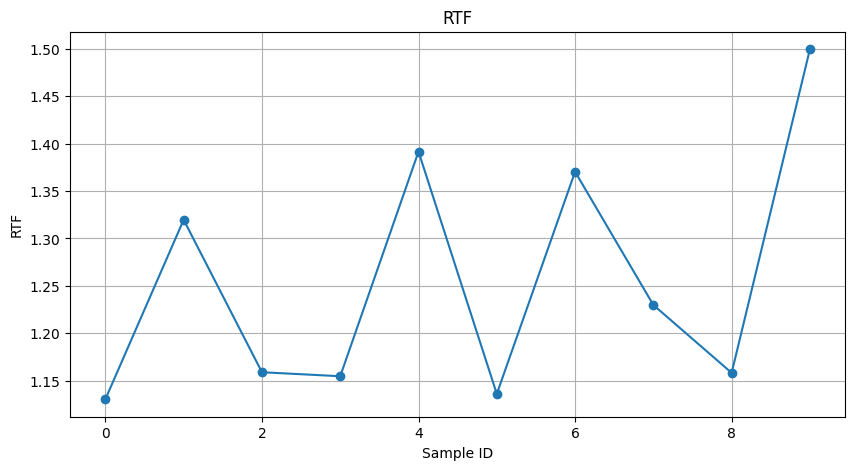

[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:12] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

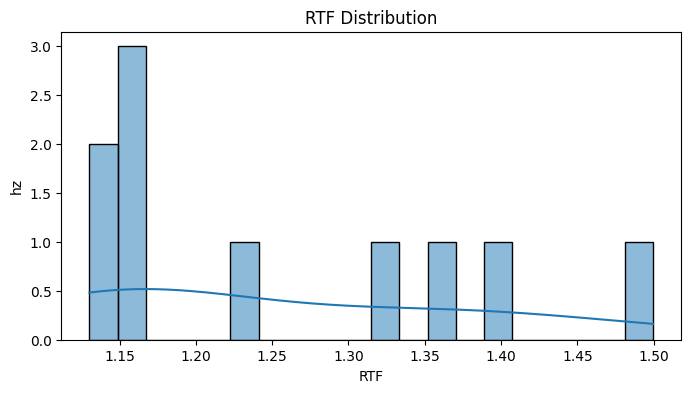

In [106]:
# RTF 折线图
plt.figure(figsize=(10,5))
plt.plot(range(len(rtf_values)), rtf_values, marker='o')
plt.title("RTF")
plt.xlabel("Sample ID")
plt.ylabel("RTF")
plt.grid(True)
plt.show()


### 11.2 资源占用情况

[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

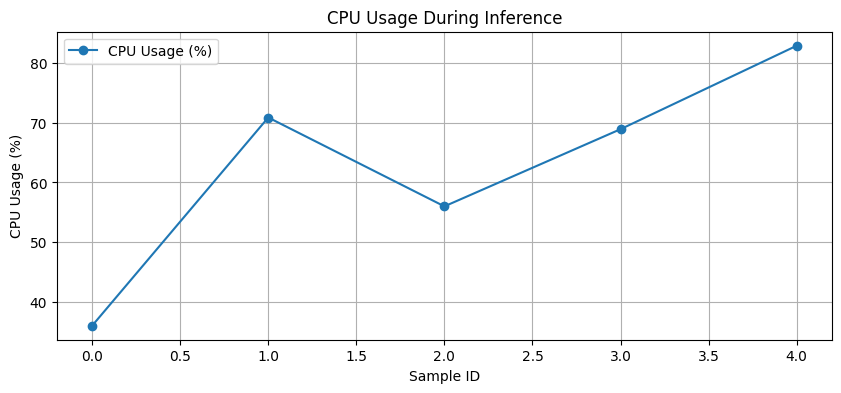

[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 07:38:54] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

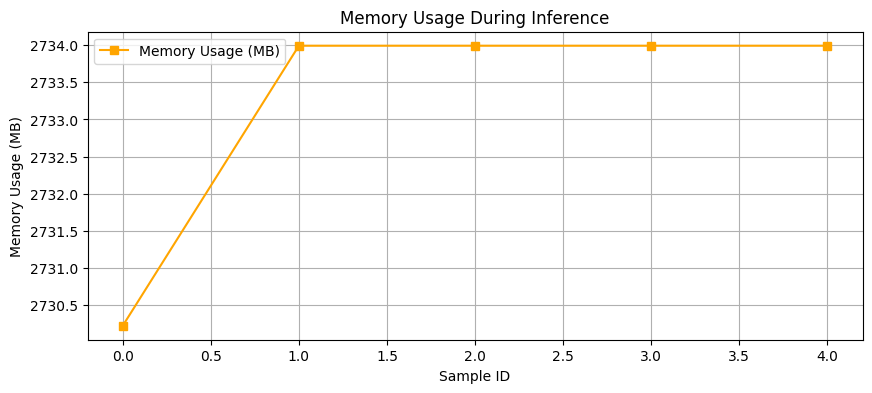

In [ ]:
# CPU 使用率折线图
plt.figure(figsize=(10,4))
plt.plot(range(len(cpu_usages)), cpu_usages, marker='o', label='CPU Usage (%)')
plt.title("CPU Usage During Inference")
plt.xlabel("Sample ID")
plt.ylabel("CPU Usage (%)")
plt.grid(True)
plt.legend()
plt.show()

# 内存使用折线图
plt.figure(figsize=(10,4))
plt.plot(range(len(mem_usages)), mem_usages, marker='s', color='orange', label='Memory Usage (MB)')
plt.title("Memory Usage During Inference")
plt.xlabel("Sample ID")
plt.ylabel("Memory Usage (MB)")
plt.grid(True)
plt.legend()
plt.show()

### 11.3 音质评估

[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:33:59] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

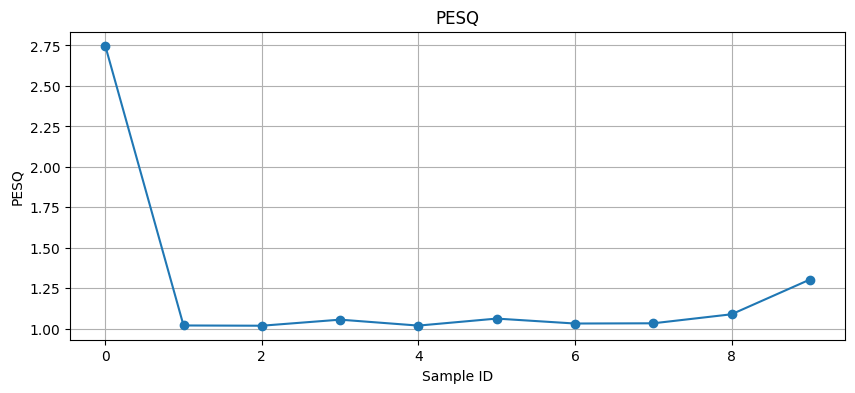

[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
[+0000 20250120 08:34:00] [WARN] matplotlib.font_manager | font_manager | findfont: Generic family '

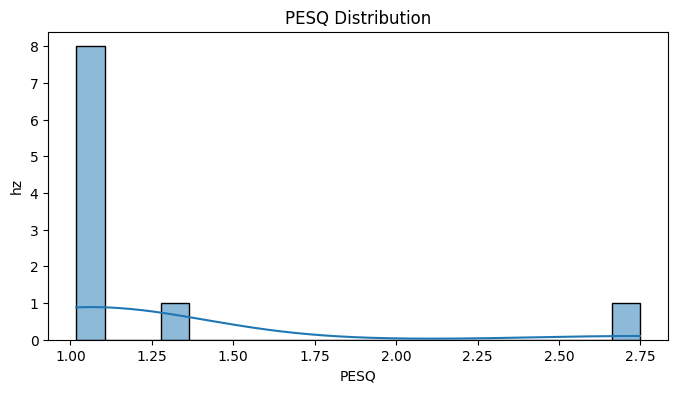

In [108]:
# PESQ 折线图
plt.figure(figsize=(10,4))
plt.plot(range(len(pesq_scores)), pesq_scores, marker='o')
plt.title("PESQ")
plt.xlabel("Sample ID")
plt.ylabel("PESQ")
plt.grid(True)
plt.show()

# PESQ 分布直方图
plt.figure(figsize=(8,4))
sns.histplot(pesq_scores, bins=20, kde=True)
plt.title("PESQ Distribution")
plt.xlabel("PESQ")
plt.ylabel("hz")
plt.show()